In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7

In [3]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from crossCorrLCCF_ave import *

In [4]:
from alerce.core import Alerce
client = Alerce()

In [5]:
def plotLC(oid, LC_det, A=None, redshift=None):
    
    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod / u.mag)
        reftime = LC_det.mjd.min()
    else:
        distmod = 0
        reftime = 0
        redshift = 0
        
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            
            # change time to restframe days if redshift is not zero
            times = (LC_det[mask].mjd - reftime) / (1. + redshift)
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(times, LC_det[mask].magpsf_corr - distmod, 
                    yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid], alpha=0.1)
                # show dust and distance attenuation corrected light curve
                ax.errorbar(times, LC_det[mask].magpsf_corr - A_fid - distmod, 
                    yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = "%s (ext. corr.)" % labels[fid])
            else:
                # correct only for redshift
                ax.errorbar(times, LC_det[mask].magpsf_corr - distmod, 
                    yerr = LC_det[mask].sigmapsf_corr_ext - A_fid, c = colors[fid], fmt=markers[fid], label = labels[fid])
        
            
    # labels
    if A is not None and redshift != 0:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)" % (oid, A["g"], A["r"], redshift))
    elif redshift != 0:
        ax.set_title("%s (z=%.4f)" % (oid, redshift))
    elif A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    if redshift == 0:
        ax.set_xlabel("MJD")
        ax.set_ylabel("Apparent magnitude")
    else:
        ax.set_xlabel("Restframe time [days]")
        ax.set_ylabel("Absolute magnitude (no K-corr.)")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

In [6]:
def getLCdata(oid, doLC=False, doext=False, dostamp=False, doNED=False, doredshift=False):

    results = {"oid": oid}
    
    # query basic stats
    LC_stats = client.query_object(oid, format='pandas')
    results["stats"] = LC_stats
    
    # query detections
    LC_det = client.query_detections(oid, format='pandas')
    results["lc_det"] = LC_det
    
    # object coordinates
    co = coordinates.SkyCoord(ra=LC_stats.meanra[0], dec=LC_stats.meandec[0], unit=(u.deg, u.deg), frame='fk5')
    
    # get galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]), "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLC(oid, LC_det, A)
        else:
            plotLC(oid, LC_det)
            
    # find NED galaxies
    if doNED:
        Ned_table = Ned.query_region(co, radius=2.0 * u.arcsec, equinox='J2000.0')
        display(Ned_table)
        results["ned_table"] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask=df_ned.Redshift.notna()
        if mask.sum() > 0:
            results["redshift"] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            print("Redshift found: %s" % results["redshift"])
            
    # plot absolute value (without K-corrections)
    if doredshift:
        if type(doredshift) == float and doredshift > 0:
            results["redshift"] = doredshift
        if "redshift" in results.keys():
            if doext:
                plotLC(oid, LC_det, A, results["redshift"])
            else:
                plotLC(oid, LC_det, results["redshift"])            
    
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace = 0, hspace = 0)
        
    # return data
    return results

In [7]:
fermi = pd.read_excel("photometric-monitoring.xlsx")

In [8]:
fermi

,3FHL_Name,3FHL_CLASS,3FHL_RAJ2000,3FHL_DEJ2000,Assoc1_Name,z_for_MC,z_LL,z_quality_comment,Livetime,Extension_Flag,High_S/N_spectra,Comment,Action,Spectro-Observations,Imaging-Observations
0,3FHL J0022.1-1855,bll,5.525983,-18.917013,1RXS J002209.2-185,0.774,True,NaN,20.0,N,Y?,z>0.774 Keck Shaw et al. 13 spectrum not in ar...,Spectroscopy in photometric minimum,NaN,NaN
1,3FHL J0033.5-1921,bll,8.392931,-19.357483,KUV 00311-1938,0.506,True,Clear MgII absorber,1.0,N,Y,Pita et al. 14,Spectroscopy in photometric minimum,NaN,NaN
2,3FHL J0035.2+1514,bll,8.817282,15.243119,RX J0035.2+1515,0.300,False,NaN,13.0,N,Y,"Paiano et al. 17, SDSS",Spectroscopy in photometric minimum,NaN,NaN
3,3FHL J0035.9+5950,bll,8.978161,59.835045,1ES 0033+595,0.300,False,Tentative redshift ?,1.0,NP,Y,"z=0.467 Tentative Paiano et al. 17, Nilsson et...",Spectroscopy in photometric minimum,NaN,NaN
4,3FHL J0120.4-2701,bll,20.115040,-27.027128,PKS 0118-272,0.558,True,NaN,4.0,N,Y,"Deep UVES spectra, HST imaging",Spectroscopy in photometric minimum,NaN,NaN
5,3FHL J0136.5+3906,bll,24.139187,39.101215,B3 0133+388,0.300,False,NaN,1.0,NP,Y,"Several high S/N spectra, no result",Spectroscopy in photometric minimum,NaN,NaN
6,3FHL J0211.2+1051,BLL,32.814346,10.858768,MG1 J021114+1051,0.300,False,NaN,4.0,YP,Y,Extended Meisner & Romani 2010,Spectroscopy in photometric minimum,NaN,NaN
7,3FHL J0222.6+4302,BLL,35.666264,43.034084,3C 66A,0.334,True,HST Ly alpha abs.+cluster,1.0,NP,Y,"Cluster z=0.34, Torres-Zafra et al. 18, Stadni...",Spectroscopy in photometric minimum,NaN,NaN
8,3FHL J0334.2-3726,bll,53.569492,-37.444336,PMN J0334-3725,0.300,False,NaN,16.0,n,Y,Shaw et al. 13 VLT spectrum,Spectroscopy in photometric minimum,NaN,NaN
9,3FHL J0449.4-4350,bll,72.361565,-43.833763,PKS 0447-439,0.300,False,Possible cluster,1.0,n,Y,"Cluster z=0.343, Muriel et al. 15",Spectroscopy in photometric minimum,NaN,NaN


# Blazars

In [9]:
#RX J1754.1+3212 / 4FGL J1754.2+3212 / 3FHL J1754.1+3212 / ZTF18aakyttg 
import pickle

folder = "EX1"

gammalc = open(folder+"/lc.pkl", "rb")

rx = pickle.load(gammalc)

#create a mask to plot upper limits the bins that have a TS<9
n = 4
mask_ul = rx["ts"] <= n
mask_det = rx["ts"] > n

tmean = (rx['tmin_mjd'] + rx['tmax_mjd'])/2

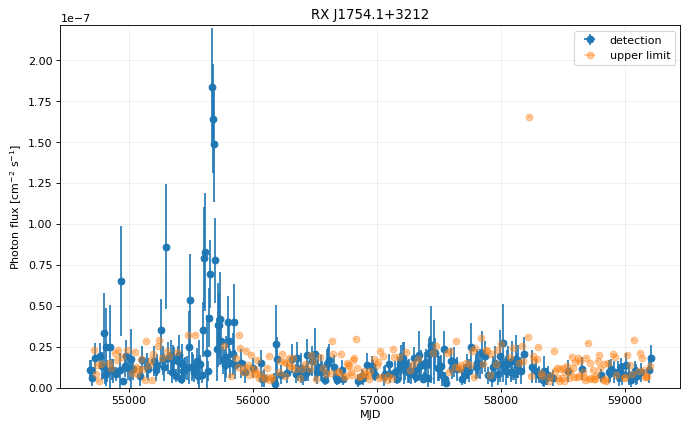

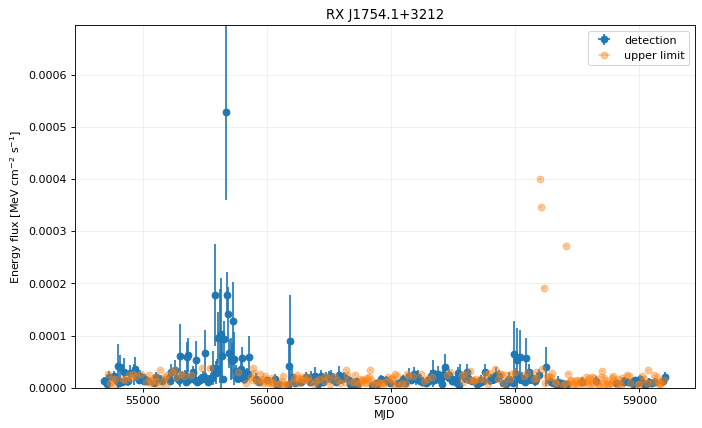

In [10]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection

plt.errorbar(tmean[mask_det], rx['flux'][mask_det], yerr=rx['flux_err'][mask_det],xerr=10, linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean[mask_ul], rx['flux_ul95'][mask_ul], xerr=10, linestyle='None', marker='o', label="upper limit", alpha = 0.4)

plt.title("RX J1754.1+3212")
plt.ylim(0, np.max(rx['flux'][mask_det])+ np.max(rx['flux_err'][mask_det]))
plt.xlabel('MJD')
plt.ylabel('Photon flux [cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

#Energy flux
plt.figure(figsize=(10, 6), dpi=80)

plt.errorbar(tmean[mask_det], rx['eflux'][mask_det], yerr=rx['eflux_err'][mask_det],xerr=10, linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean[mask_ul], rx['eflux_ul95'][mask_ul], xerr=10, linestyle='None', marker='o', label="upper limit", alpha = 0.4)



plt.ylim(0, np.max(rx['eflux'][mask_det])+ np.max(rx['eflux_err'][mask_det]))
plt.title("RX J1754.1+3212")
plt.xlabel('MJD')
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [11]:
#Optical data

rxZTF  = getLCdata("ZTF18aakyttg") #, doLC=True);

def mag2uJy(mag):
    return 10**((8.9 - mag) / 2.5) * 1e6
def emag2euJy(mag, emag):
    return (mag2uJy(mag - emag) - mag2uJy(mag))

In [12]:
flux = mag2uJy(rxZTF["lc_det"].magpsf_corr)
flux_e = emag2euJy(rxZTF["lc_det"].magpsf_corr, rxZTF["lc_det"].sigmapsf_corr)

rxZTF["lc_det"]["flux"] = flux
rxZTF["lc_det"]["flux_e"] = flux_e

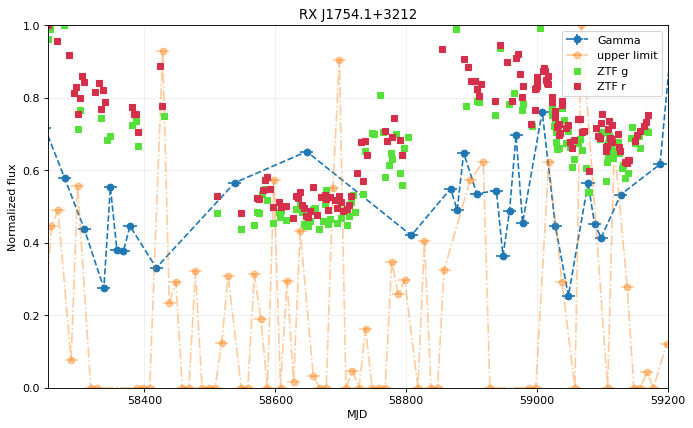

In [13]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
mask_dates = (tmean>np.min(rxZTF["lc_det"].mjd)) & (tmean<np.max(rxZTF["lc_det"].mjd))

plt.errorbar(tmean[mask_det], rx['flux'][mask_det]/np.max(rx['flux'][mask_det&mask_dates]), 
             yerr=rx['flux_err'][mask_det],xerr=10, linestyle='--', marker='o', label="Gamma")

#Upper limits
plt.errorbar(tmean[mask_ul], rx['eflux'][mask_ul]/np.max(rx['eflux'][mask_ul&mask_dates]), xerr=10, linestyle='-.', marker='o', label="upper limit", alpha = 0.4)


labels = {1: 'g', 2: 'r'}
colors = {1: '#56E03A', 2: '#D42F4B'}
markers = {1: 'o', 2: 's'}
for fid in [1, 2]:
    maskfid = rxZTF["lc_det"]["fid"] == fid
    plt.errorbar(rxZTF["lc_det"]["mjd"][maskfid], rxZTF["lc_det"]["flux"][maskfid]/np.max(rxZTF["lc_det"]["flux"][maskfid]),
                 yerr = None, marker='s', c=colors[fid], label="ZTF "+ labels[fid], linestyle="None")

#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("RX J1754.1+3212")
plt.xlabel('MJD')
plt.ylabel('Normalized flux')
plt.legend()
plt.grid(alpha=0.2)
plt.xlim(np.min(rxZTF["lc_det"]["mjd"]), 59200) 
plt.ylim(0,1) 
plt.show()


# RBS 0970

In [62]:
import pickle
gammalc1 = open("EX3/lc1.pkl", "rb")
gammalc2 = open("EX3/lc2.pkl", "rb")

lc1 = pickle.load(gammalc1)
lc2 = pickle.load(gammalc2)
#print(lc2)

In [63]:
#create a mask to plot upper limits the bins that have a TS<9
n = 4
mask_ul1 = lc1["ts"]<=n
mask_det1 = lc1["ts"]>n

tmean1 = (lc1['tmin_mjd'] + lc1['tmax_mjd'])/2

mask_ul2 = lc2["ts"]<=n
mask_det2 = lc2["ts"]>n

tmean2 = (lc2['tmin_mjd'] + lc2['tmax_mjd'])/2

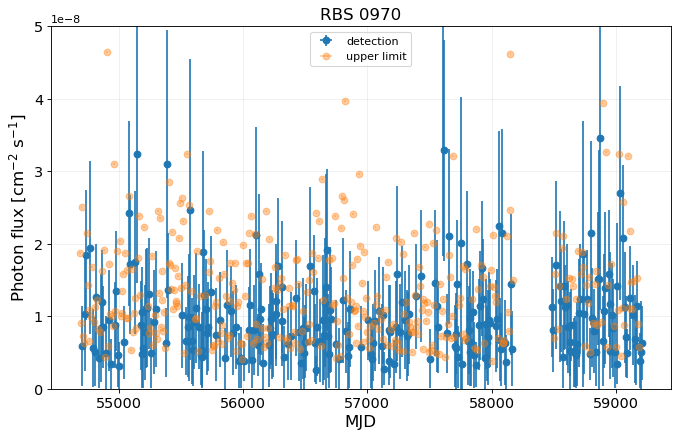

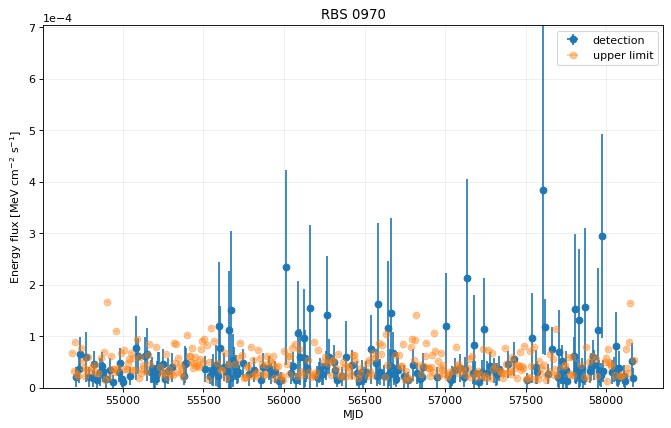

In [64]:
%matplotlib notebook
%matplotlib inline
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
plt.errorbar(tmean1[mask_det1], lc1['flux'][mask_det1], yerr=lc1['flux_err'][mask_det1], xerr=7,
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['flux_ul95'][mask_ul1], xerr=7, linestyle='None', marker='o', 
             label="upper limit", alpha = 0.4)


#detection
plt.errorbar(tmean2[mask_det2], lc2['flux'][mask_det2], yerr=lc2['flux_err'][mask_det2], xerr=7,
             linestyle='None', marker='o', color='#1f77b4')#, label="detection")

#Upper limits
plt.errorbar(tmean2[mask_ul2], lc2['flux_ul95'][mask_ul2], xerr=7, linestyle='None', marker='o', 
             alpha=0.4, color="#ff7f0e") #label="upper limit", alpha = 0.4)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("RBS 0970", fontsize=15)
#plt.ylim(0, np.max(lc1['flux'][mask_det1])+ np.max(lc1['flux_err'][mask_det1]))
plt.xlabel('MJD', fontsize=15)
plt.ylabel('Photon flux [cm$^{-2}$ s$^{-1}$]', fontsize=15)
plt.legend()
plt.grid(alpha=0.2)
plt.ylim(0., 0.5*1e-7)

plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)

plt.show()

#Energy flux
plt.figure(figsize=(10, 6), dpi=80)

plt.errorbar(tmean1[mask_det1], lc1['eflux'][mask_det1], yerr=lc1['eflux_err'][mask_det1],xerr=7, 
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['eflux_ul95'][mask_ul1], xerr=7, 
             linestyle='None', marker='o', label="upper limit", alpha = 0.4)



plt.ylim(0, np.max(lc1['eflux'][mask_det1])+ np.max(lc1['eflux_err'][mask_det1]))

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("RBS 0970")
plt.xlabel('MJD')
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [65]:
cat = pd.read_csv("EX3/catalina.csv")

flux_cat= mag2uJy(cat["Mag"])
flux_e_cat  = emag2euJy(cat["Mag"], cat["Magerr"])

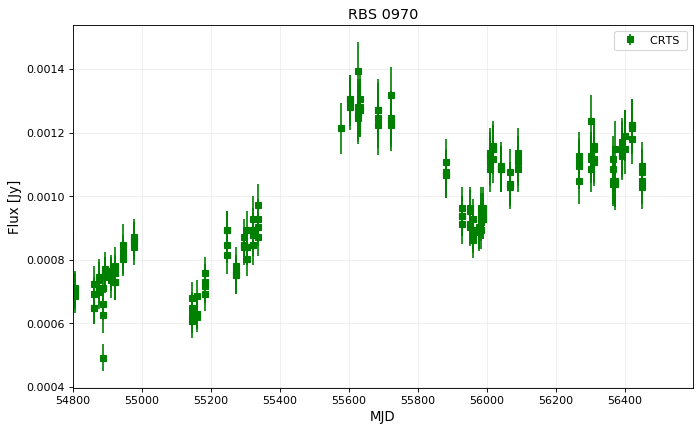

In [66]:
plt.figure(figsize=(10, 6), dpi=80)

plt.errorbar(cat["MJD"], flux_cat*1e-6,
                 yerr = flux_e_cat*1e-6, marker='s', c="g", label="CRTS ", linestyle="None")

#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("RBS 0970", fontsize=13)
plt.xlabel('MJD', fontsize=12)
plt.ylabel('Flux [Jy]', fontsize=12)
plt.legend()
plt.xlim(54800, None)
#plt.xlim(np.min(lc1['tmin_mjd']), np.max(cat["MJD"]))
#plt.ylim(0,1.15)
plt.grid(alpha=0.2)

In [67]:
len(mask_dates)

104

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

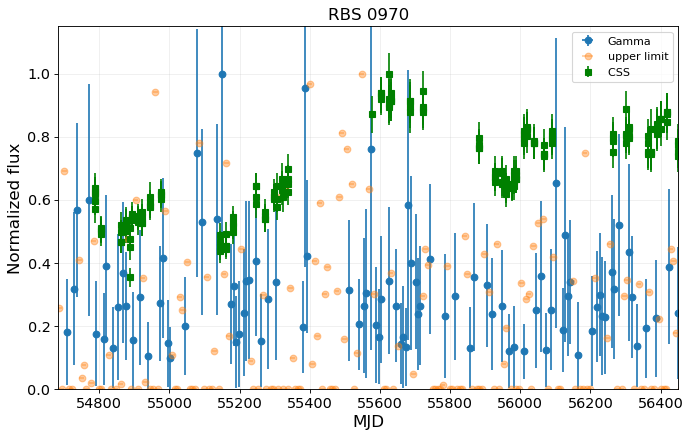

In [68]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
mask_dates = (tmean1>np.min(cat.MJD)) & (tmean1<np.max(cat.MJD))

plt.errorbar(tmean1[mask_det1], lc1['flux'][mask_det1]/np.max(lc1['flux'][mask_det1 & mask_dates]), 
             yerr=lc1['flux_err'][mask_det1]/np.max(lc1['flux'][mask_det1 & mask_dates]),
             xerr=7, linestyle='None', marker='o', label="Gamma")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['eflux'][mask_ul1]/np.max(lc1['eflux'][mask_ul1&mask_dates]), xerr=7, linestyle='None', marker='o', label="upper limit", alpha = 0.4)


labels = {1: 'g', 2: 'r'}
colors = {1: '#56E03A', 2: '#D42F4B'}
markers = {1: 'o', 2: 's'}
#for fid in [1, 2]:
 #   maskfid = opt["lc_det"]["fid"] == fid
  #  plt.errorbar(opt["lc_det"]["mjd"][maskfid], opt["lc_det"]["flux"][maskfid]/np.max(opt["lc_det"]["flux"][maskfid]),
   #              yerr = None, marker='s', c=colors[fid], label="ZTF "+ labels[fid], linestyle="-.")

plt.errorbar(cat["MJD"], flux_cat/np.max(flux_cat),
                 yerr = flux_e_cat/np.max(flux_cat), marker='s', c="g", label="CSS ", linestyle="None")

#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("RBS 0970", fontsize = 15)
plt.xlabel('MJD', fontsize =15)
plt.ylabel('Normalized flux', fontsize = 15)
plt.legend()
plt.xlim(np.min(lc1['tmin_mjd']), np.max(cat["MJD"]))
plt.ylim(0,1.15)
plt.grid(alpha=0.2)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)

In [69]:
opt  = getLCdata("ZTF18aahfflo")# , doLC=True);

In [70]:
n = 4
mask_ul = lc2["ts"]<=n
mask_det = lc2["ts"]>n

tmean = (lc2['tmin_mjd'] + lc2['tmax_mjd'])/2


flux = mag2uJy(opt["lc_det"].magpsf_corr)
flux_e = emag2euJy(opt["lc_det"].magpsf_corr, opt["lc_det"].sigmapsf)

opt["lc_det"]["flux"] = flux
opt["lc_det"]["flux_e"] = flux_e

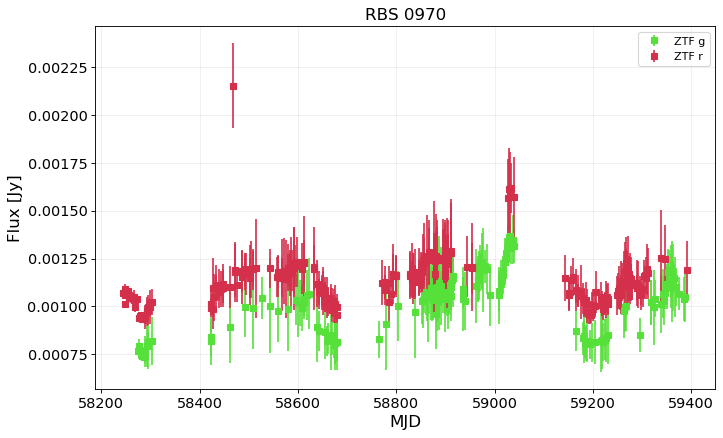

In [71]:
plt.figure(figsize=(10, 6), dpi=80)

labels = {1: 'g', 2: 'r'}
colors = {1: '#56E03A', 2: '#D42F4B'}
markers = {1: 'o', 2: 's'}
for fid in [1, 2]:
    maskfid = opt["lc_det"]["fid"] == fid
    plt.errorbar(opt["lc_det"]["mjd"][maskfid], opt["lc_det"]["flux"][maskfid]*1e-6, 
    yerr = opt["lc_det"]["flux_e"][maskfid]*1e-6, marker='s', c=colors[fid], label="ZTF "+ labels[fid], 
    linestyle="None")


#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("RBS 0970", fontsize=15)
plt.xlabel('MJD', fontsize=15)
plt.ylabel('Flux [Jy]', fontsize=15)
plt.legend()
#plt.xlim(np.min(lc1['tmin_mjd']), np.max(cat["MJD"]))
#plt.ylim(0,1.15)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.grid(alpha=0.2)

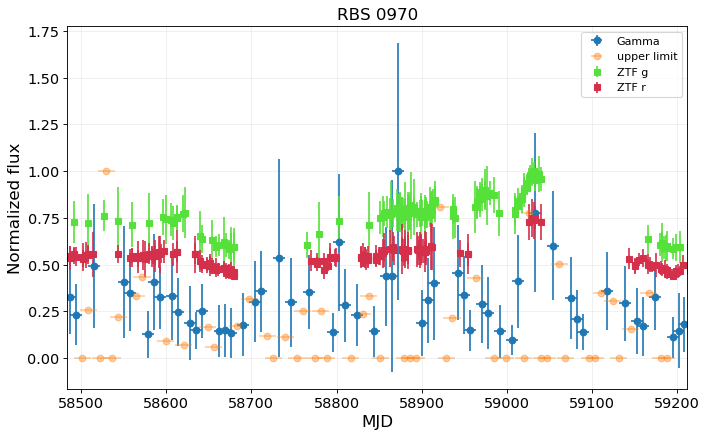

In [72]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
mask_dates = True #(tmean>np.min(opt["lc_det"].mjd)) & (tmean<np.max(opt["lc_det"].mjd))

plt.errorbar(tmean[mask_det], lc2['flux'][mask_det]/np.max(lc2['flux'][mask_det&mask_dates]), 
             yerr=lc2['flux_err'][mask_det]/np.max(lc2['flux'][mask_det&mask_dates]),
             xerr=7, linestyle='None', marker='o', label="Gamma")

#Upper limits
plt.errorbar(tmean[mask_ul], lc2['eflux'][mask_ul]/np.max(lc2['eflux'][mask_ul&mask_dates]), xerr=10, linestyle='None', marker='o', label="upper limit", alpha = 0.4)


labels = {1: 'g', 2: 'r'}
colors = {1: '#56E03A', 2: '#D42F4B'}
markers = {1: 'o', 2: 's'}
for fid in [1, 2]:
    maskfid = opt["lc_det"]["fid"] == fid
    plt.errorbar(opt["lc_det"]["mjd"][maskfid], opt["lc_det"]["flux"][maskfid]/np.max(opt["lc_det"]["flux"][maskfid]),
                 yerr = opt["lc_det"]["flux_e"][maskfid]/np.max(opt["lc_det"]["flux"][maskfid]), 
                 marker='s', c=colors[fid], label="ZTF "+ labels[fid], linestyle="None")

#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("RBS 0970", fontsize=15)
plt.xlabel('MJD', fontsize=15)
plt.ylabel('Normalized flux', fontsize=15)
plt.legend()
plt.grid(alpha=0.2)
plt.xlim(np.min(lc2['tmin_mjd']), np.max(lc2['tmax_mjd']))

plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.show()

In [73]:
RBS_ztf = {'flux_ztf': opt["lc_det"].flux*1e-6,'eflux_ztf': opt["lc_det"].flux_e*1e-6, 
         'mjd_ztf': opt["lc_det"].mjd, "fid": opt["lc_det"].fid}

RBS_fermi = {'flux_fermi':lc2['flux'][mask_det2], 'eflux_fermi': lc2['flux_err'][mask_det2], 
               'mjd_fermi': tmean2[mask_det2]}      

In [74]:
df_ztf = pd.DataFrame(RBS_ztf) 
df_fermi = pd.DataFrame(RBS_fermi)

In [75]:
maskg = df_ztf.fid == 1
maskr = df_ztf.fid == 2

In [76]:
xcorr = crosscorr(df_ztf[maskg].mjd_ztf, df_ztf[maskg].flux_ztf, df_ztf[maskg].eflux_ztf,
          df_fermi.mjd_fermi, df_fermi.flux_fermi, df_fermi.eflux_fermi, 10)
xcorr

/home/javier/codigos/FermiLat/crossCorrLCCF_ave.py:146: RuntimeWarning: invalid value encountered in double_scalars
  sqrt(var(x, ddof=0) * var(y, ddof=0))


(array([-900., -890., -880., -870., -860., -850., -840., -830., -820.,
        -810., -800., -790., -780., -770., -760., -750., -740., -730.,
        -720., -710., -700., -690., -680., -670., -660., -650., -640.,
        -630., -620., -610., -600., -590., -580., -570., -560., -550.,
        -540., -530., -520., -510., -500., -490., -480., -470., -460.,
        -450., -440., -430., -420., -410., -400., -390., -380., -370.,
        -360., -350., -340., -330., -320., -310., -300., -290., -280.,
        -270., -260., -250., -240., -230., -220., -210., -200., -190.,
        -180., -170., -160., -150., -140., -130., -120., -110., -100.,
         -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,  -10.,
           0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
      

Text(0, 0.5, 'DCF')

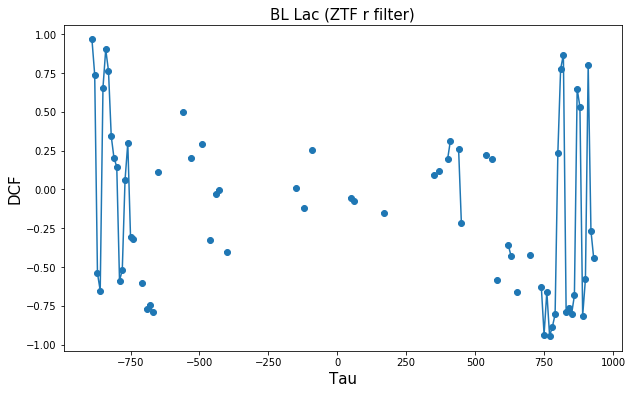

In [77]:
%matplotlib inline
plt.figure(figsize=(10,6))
#plt.plot(xcorr[0], xcorr[2], '.')

plt.errorbar(xcorr[0], xcorr[2], xerr=xcorr[1], yerr=xcorr[3], linestyle="-", marker="o")

plt.title("BL Lac (ZTF r filter)", fontsize=15)
plt.xlabel("Tau", fontsize=15)
plt.ylabel("DCF", fontsize=15)
#plt.xlim(-100, 100)

In [78]:
xcorr = crosscorr(df_ztf[maskr].mjd_ztf, df_ztf[maskr].flux_ztf, df_ztf[maskr].eflux_ztf,
          df_fermi.mjd_fermi, df_fermi.flux_fermi, df_fermi.eflux_fermi, 10)
xcorr

(array([-900., -850., -840., -830., -820., -810., -800., -790., -780.,
        -770., -760., -750., -740., -730., -720., -710., -700., -690.,
        -680., -670., -660., -650., -640., -630., -620., -610., -600.,
        -590., -580., -570., -560., -550., -540., -530., -520., -510.,
        -500., -490., -480., -470., -460., -450., -440., -430., -420.,
        -410., -400., -390., -380., -370., -360., -350., -340., -330.,
        -320., -310., -300., -290., -280., -270., -260., -250., -240.,
        -230., -220., -210., -200., -190., -180., -170., -160., -150.,
        -140., -130., -120., -110., -100.,  -90.,  -80.,  -70.,  -60.,
         -50.,  -40.,  -30.,  -20.,  -10.,    0.,   10.,   20.,   30.,
          40.,   50.,   60.,   70.,   80.,   90.,  100.,  110.,  120.,
         130.,  140.,  150.,  160.,  170.,  180.,  190.,  200.,  210.,
         220.,  230.,  240.,  250.,  260.,  270.,  280.,  290.,  300.,
         310.,  320.,  330.,  340.,  350.,  360.,  370.,  380.,  390.,
      

(-100, 100)

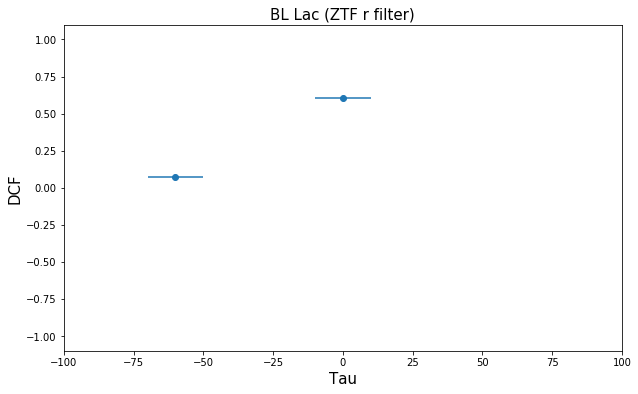

In [31]:
%matplotlib inline
plt.figure(figsize=(10,6))
#plt.plot(xcorr[0], xcorr[2], '.')

plt.errorbar(xcorr[0], xcorr[2], xerr=xcorr[1], yerr=xcorr[3], linestyle="-", marker="o")

plt.title("BL Lac (ZTF r filter)", fontsize=15)
plt.xlabel("Tau", fontsize=15)
plt.ylabel("DCF", fontsize=15)
plt.xlim(-100, 100)

In [32]:
#cat = pd.read_csv(folder+"/catalina.csv")

## 3C 66A

In [33]:
folder = "3c66a"

lc1 = open(folder+"/lc1.pkl", "rb")
lc2 = open(folder+"/lc2.pkl", "rb")

lc1 = pickle.load(lc1)
lc2 = pickle.load(lc2)

#create a mask to plot upper limits the bins that have a TS<9
n = 4
mask_ul1 = lc1["ts"] <= n
mask_det1 = lc1["ts"] > n
mask_ul2 = lc2["ts"] <= n
mask_det2 = lc2["ts"] > n

tmean1 = (lc1['tmin_mjd'] + lc1['tmax_mjd'])/2
tmean2 = (lc2['tmin_mjd'] + lc2['tmax_mjd'])/2

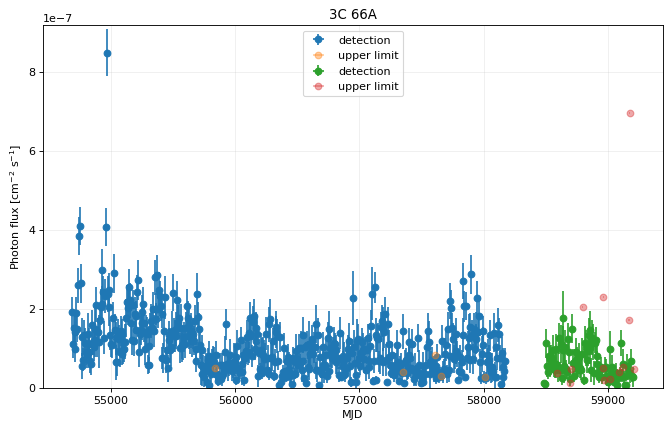

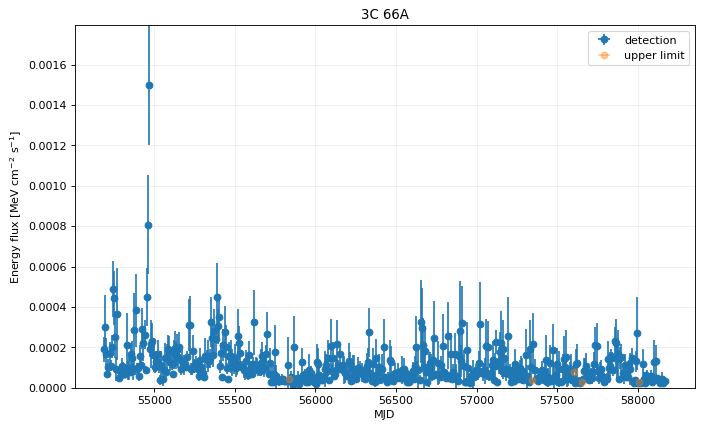

In [34]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
plt.errorbar(tmean1[mask_det1], lc1['flux'][mask_det1], yerr=lc1['flux_err'][mask_det1], xerr=7,
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['flux_ul95'][mask_ul1], xerr=7, linestyle='None', marker='o', 
             label="upper limit", alpha = 0.4)


#detection
plt.errorbar(tmean2[mask_det2], lc2['flux'][mask_det2], yerr=lc2['flux_err'][mask_det2], xerr=7,
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean2[mask_ul2], lc2['flux_ul95'][mask_ul2], xerr=7, linestyle='None', marker='o', 
             label="upper limit", alpha = 0.4)



plt.title("3C 66A")
plt.ylim(0, np.max(lc1['flux'][mask_det1])+ np.max(lc1['flux_err'][mask_det1]))
plt.xlabel('MJD')
plt.ylabel('Photon flux [cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

#Energy flux
plt.figure(figsize=(10, 6), dpi=80)

plt.errorbar(tmean1[mask_det1], lc1['eflux'][mask_det1], yerr=lc1['eflux_err'][mask_det1],xerr=7, 
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['eflux_ul95'][mask_ul1], xerr=7, 
             linestyle='None', marker='o', label="upper limit", alpha = 0.4)



plt.ylim(0, np.max(lc1['eflux'][mask_det1])+ np.max(lc1['eflux_err'][mask_det1]))
plt.title("3C 66A")
plt.xlabel('MJD')
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [35]:
#second part combine with ZTF

In [36]:
# 3c66a 
ra = 35.6650
dec = 43.0350


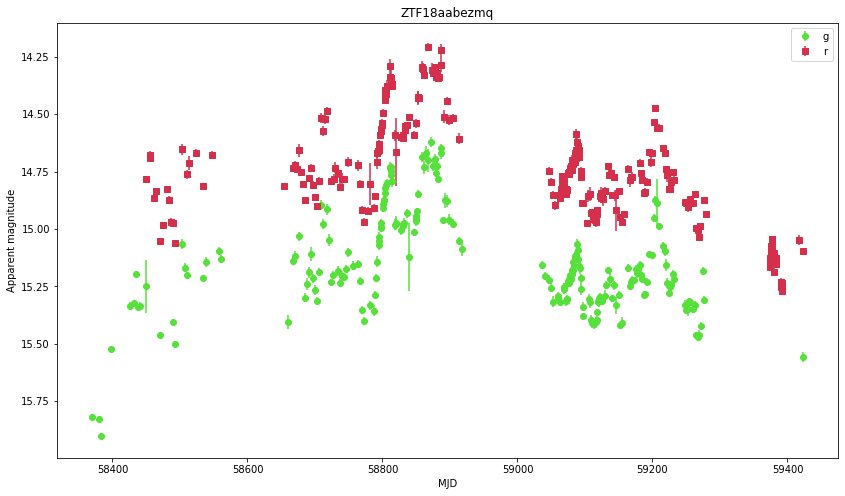

In [37]:
#Optical data

ZTF3c66a  = getLCdata("ZTF18aabezmq" , doLC=True);


In [38]:
flux = mag2uJy(ZTF3c66a["lc_det"].magpsf_corr)
flux_e = emag2euJy(ZTF3c66a["lc_det"].magpsf_corr, ZTF3c66a["lc_det"].sigmapsf)

ZTF3c66a["lc_det"]["flux"] = flux
ZTF3c66a["lc_det"]["flux_e"] = flux_e

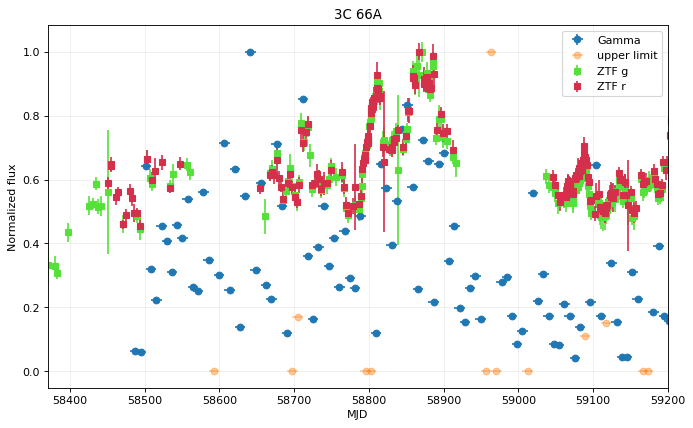

In [39]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
mask_dates = (tmean2>np.min(ZTF3c66a["lc_det"].mjd)) & (tmean2<np.max(ZTF3c66a["lc_det"].mjd))

plt.errorbar(tmean2[mask_det2], lc2['flux'][mask_det2]/np.max(lc2['flux'][mask_det2&mask_dates]), 
             yerr=lc2['flux_err'][mask_det2],xerr=7, linestyle='None', marker='o', label="Gamma")

#Upper limits
plt.errorbar(tmean2[mask_ul2], lc2['eflux'][mask_ul2]/np.max(lc2['eflux'][mask_ul2&mask_dates]), xerr=7, 
             linestyle='None', marker='o', label="upper limit", alpha = 0.4)


labels = {1: 'g', 2: 'r'}
colors = {1: '#56E03A', 2: '#D42F4B'}
markers = {1: 'o', 2: 's'}
for fid in [1, 2]:
    maskfid = ZTF3c66a["lc_det"]["fid"] == fid
    plt.errorbar(ZTF3c66a["lc_det"]["mjd"][maskfid], ZTF3c66a["lc_det"]["flux"][maskfid]/np.max(ZTF3c66a["lc_det"]["flux"][maskfid]),
                 yerr = ZTF3c66a["lc_det"]["flux_e"][maskfid]/np.max(ZTF3c66a["lc_det"]["flux"][maskfid]), marker='s', c=colors[fid], 
                 label="ZTF "+ labels[fid], linestyle="None")

#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("3C 66A")
plt.xlabel('MJD')
plt.ylabel('Normalized flux')
plt.legend()
plt.grid(alpha=0.2)
plt.xlim(np.min(ZTF3c66a["lc_det"]["mjd"]), 59200) 
#plt.ylim(0,1) 
plt.show()

## BL Lac

In [40]:
folder = "BLLac"

lc1 = open(folder+"/lc1.pkl", "rb")
lc2 = open(folder+"/lc2.pkl", "rb")

lc1 = pickle.load(lc1)
lc2 = pickle.load(lc2)

#create a mask to plot upper limits the bins that have a TS<9
n = 4
mask_ul1 = lc1["ts"] <= n
mask_det1 = lc1["ts"] > n
mask_ul2 = lc2["ts"] <= n
mask_det2 = lc2["ts"] > n

tmean1 = (lc1['tmin_mjd'] + lc1['tmax_mjd'])/2
tmean2 = (lc2['tmin_mjd'] + lc2['tmax_mjd'])/2

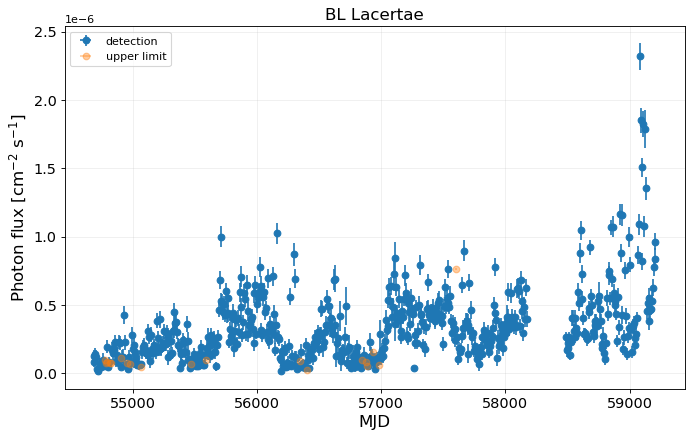

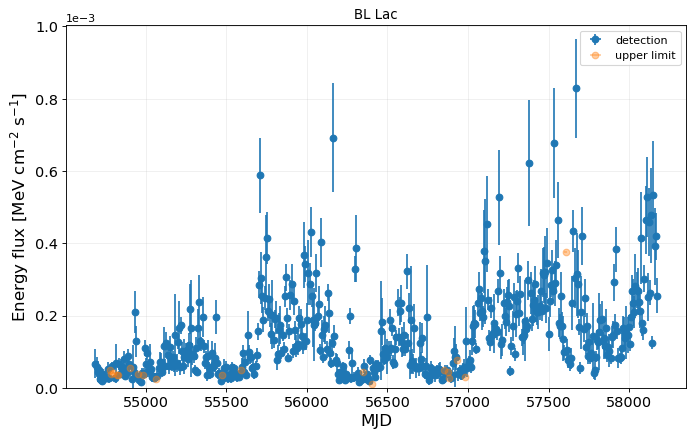

In [41]:


#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
plt.errorbar(tmean1[mask_det1], lc1['flux'][mask_det1], yerr=lc1['flux_err'][mask_det1], xerr=7,
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['flux_ul95'][mask_ul1], xerr=7, linestyle='None', marker='o', 
             label="upper limit", alpha = 0.4)


#detection
plt.errorbar(tmean2[mask_det2], lc2['flux'][mask_det2], yerr=lc2['flux_err'][mask_det2], xerr=7,
             linestyle='None', marker='o', color='#1f77b4')#, label="detection")

#Upper limits
plt.errorbar(tmean2[mask_ul2], lc2['flux_ul95'][mask_ul2], xerr=7, linestyle='None', marker='o', 
             alpha=0.4, color="#ff7f0e") #label="upper limit", alpha = 0.4)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("BL Lacertae", fontsize=15)
#plt.ylim(0, np.max(lc1['flux'][mask_det1])+ np.max(lc1['flux_err'][mask_det1]))
plt.xlabel('MJD', fontsize=15)
plt.ylabel('Photon flux [cm$^{-2}$ s$^{-1}$]', fontsize=15)
plt.legend()
plt.grid(alpha=0.2)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.show()

#Energy flux
plt.figure(figsize=(10, 6), dpi=80)

plt.errorbar(tmean1[mask_det1], lc1['eflux'][mask_det1], yerr=lc1['eflux_err'][mask_det1],xerr=7, 
             linestyle='None', marker='o', label="detection")

#Upper limits
plt.errorbar(tmean1[mask_ul1], lc1['eflux_ul95'][mask_ul1], xerr=7, 
             linestyle='None', marker='o', label="upper limit", alpha = 0.4)



plt.ylim(0, np.max(lc1['eflux'][mask_det1])+ np.max(lc1['eflux_err'][mask_det1]))

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("BL Lac")
plt.xlabel('MJD', fontsize=15)
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]', fontsize=15)
plt.legend()
plt.grid(alpha=0.2)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.show()

In [42]:
name = "BLLac"
ra = 330.680
dec = 42.2780

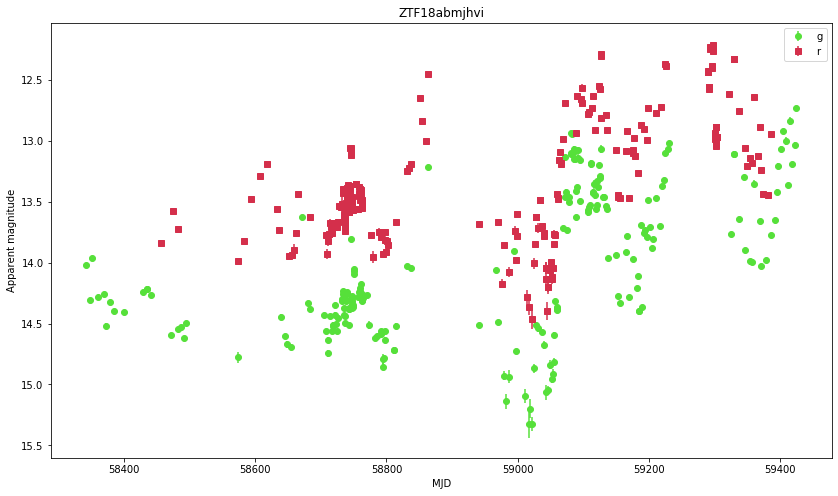

In [43]:
%matplotlib notebook
%matplotlib inline

BLLacZTF  = getLCdata("ZTF18abmjhvi" , doLC=True);

In [44]:
flux = mag2uJy(BLLacZTF["lc_det"].magpsf_corr)
flux_e = emag2euJy(BLLacZTF["lc_det"].magpsf_corr, BLLacZTF["lc_det"].sigmapsf)

BLLacZTF["lc_det"]["flux"] = flux
BLLacZTF["lc_det"]["flux_e"] = flux_e

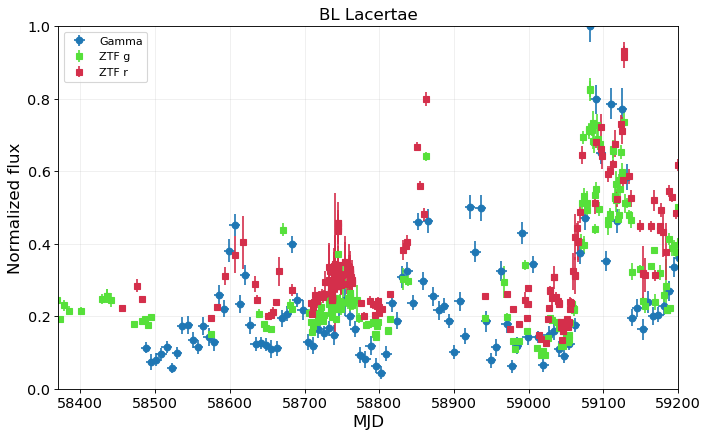

In [45]:
#Photon flux
plt.figure(figsize=(10, 6), dpi=80)

#detection
mask_dates = (tmean2>np.min(BLLacZTF["lc_det"].mjd)) & (tmean2<np.max(BLLacZTF["lc_det"].mjd))

plt.errorbar(tmean2[mask_det2], lc2['flux'][mask_det2]/np.max(lc2['flux'][mask_det2&mask_dates]), 
             yerr=lc2['flux_err'][mask_det2]/np.max(lc2['flux'][mask_det2&mask_dates]),xerr=7, linestyle='None', marker='o', label="Gamma")

#Upper limits
#plt.errorbar(tmean2[mask_ul2], lc2['eflux'][mask_ul2]/np.max(lc2['eflux'][mask_ul2&mask_dates]), xerr=7, 
 #            linestyle='None', marker='o', label="upper limit", alpha = 0.4)


labels = {1: 'g', 2: 'r'}
colors = {1: '#56E03A', 2: '#D42F4B'}
markers = {1: 'o', 2: 's'}
for fid in [1, 2]:
    maskfid = BLLacZTF["lc_det"]["fid"] == fid
    plt.errorbar(BLLacZTF["lc_det"]["mjd"][maskfid], BLLacZTF["lc_det"]["flux"][maskfid]/np.max(BLLacZTF["lc_det"]["flux"][maskfid]),
                 yerr = BLLacZTF["lc_det"]["flux_e"][maskfid]/np.max(BLLacZTF["lc_det"]["flux"][maskfid]), marker='s', c=colors[fid], label="ZTF "+ labels[fid], linestyle="None")

#plt.ylim(0, np.max(lc['flux'][mask_det])+ np.max(lc['flux_err'][mask_det]))
plt.title("BL Lacertae", fontsize = 15)
plt.xlabel('MJD', fontsize = 15)
plt.ylabel('Normalized flux', fontsize = 15)
plt.legend()
plt.grid(alpha=0.2)
plt.xlim(np.min(ZTF3c66a["lc_det"]["mjd"]), 59200) 
plt.ylim(0,1) 
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.show()

<ErrorbarContainer object of 3 artists>

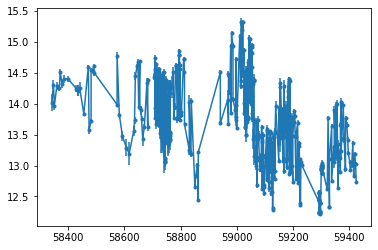

In [46]:
plt.errorbar(BLLacZTF["lc_det"].mjd, BLLacZTF["lc_det"].magpsf_corr, yerr=BLLacZTF["lc_det"].sigmapsf, marker=".")

In [47]:
BLLacZTF["lc_det"].columns

Index(['mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid', 'flux',
       'flux_e'],
      dtype='object')

In [48]:
BLLacZTF["lc_det"].sigmapsf

0      0.133967
1      0.071312
2      0.073826
3      0.063808
4      0.052407
         ...   
512    0.026394
513    0.042757
514    0.032907
515    0.032147
516    0.020993
Name: sigmapsf, Length: 517, dtype: float64

<ErrorbarContainer object of 3 artists>

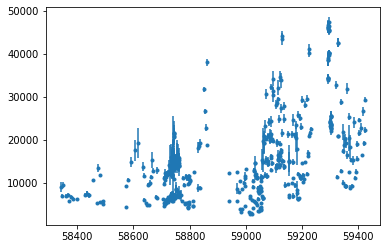

In [49]:
plt.errorbar(BLLacZTF["lc_det"].mjd, BLLacZTF["lc_det"].flux, yerr=BLLacZTF["lc_det"].flux_e, marker=".", linestyle="None")

In [50]:
import sys  
sys.path.insert(0, '/crosscorrelation/crosscorrelation')

In [51]:
BLLac_ztf = {'flux_ztf': BLLacZTF["lc_det"].flux*1e-6,'eflux_ztf': BLLacZTF["lc_det"].flux_e*1e-6, 
         'mjd_ztf': BLLacZTF["lc_det"].mjd, "fid": BLLacZTF["lc_det"].fid}

BLLac_fermi = {'flux_fermi':lc2['flux'][mask_det2], 'eflux_fermi': lc2['flux_err'][mask_det2], 
               'mjd_fermi': tmean2[mask_det2]}        

In [52]:
df_ztf = pd.DataFrame(BLLac_ztf) 
df_fermi = pd.DataFrame(BLLac_fermi)
#, columns = ['flux_ztf', 'eflux_ztf, mjd_ztf']) # , flux_fermi', 'eflux_fermi, mjd_fermi'])

In [53]:
df_fermi.head()

,flux_fermi,eflux_fermi,mjd_fermi
0,2.632898e-07,3.725662e-08,58487.494803
1,1.687593e-07,5.088268e-08,58494.494803
2,1.871170e-07,4.404654e-08,58501.494803
3,2.196048e-07,4.211993e-08,58508.494803
4,2.677169e-07,3.830873e-08,58515.494803


In [54]:
df_ztf.head()

,flux_ztf,eflux_ztf,mjd_ztf,fid
0,0.008959,0.001176,58342.405301,1
1,0.006865,0.000466,58348.358345,1
2,0.009421,0.000663,58351.409907,1
3,0.007014,0.000425,58360.362824,1
4,0.007201,0.000356,58369.300567,1


In [55]:
maskg = df_ztf.fid == 1
maskr = df_ztf.fid == 2

In [56]:
df_ztf[maskr].mjd_ztf

13     58456.150417
15     58475.136447
16     58482.100451
21     58574.490509
23     58582.468553
           ...     
497    59368.425035
500    59370.448229
501    59373.406991
503    59381.406551
504    59386.407697
Name: mjd_ztf, Length: 294, dtype: float64

In [57]:
from crossCorrLCCF_ave import *

In [58]:
xcorr = crosscorr(df_ztf[maskg].mjd_ztf, df_ztf[maskg].flux_ztf, df_ztf[maskg].eflux_ztf,
          df_fermi.mjd_fermi, df_fermi.flux_fermi, df_fermi.eflux_fermi, 10)
xcorr

(array([-930., -920., -910., -900., -890., -880., -870., -860., -850.,
        -840., -830., -820., -810., -800., -790., -780., -770., -760.,
        -750., -740., -730., -720., -710., -700., -690., -680., -670.,
        -660., -650., -640., -630., -620., -610., -600., -590., -580.,
        -570., -560., -550., -540., -530., -520., -510., -500., -490.,
        -480., -470., -460., -450., -440., -430., -420., -410., -400.,
        -390., -380., -370., -360., -350., -340., -330., -320., -310.,
        -300., -290., -280., -270., -260., -250., -240., -230., -220.,
        -210., -200., -190., -180., -170., -160., -150., -140., -130.,
        -120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.,   10.,   20.,   30.,   40.,   50.,
          60.,   70.,   80.,   90.,  100.,  110.,  120.,  130.,  140.,
         150.,  160.,  170.,  180.,  190.,  200.,  210.,  220.,  230.,
         240.,  250.,  260.,  270.,  280.,  290.,  300.,  310.,  320.,
      

Text(0, 0.5, 'DCF')

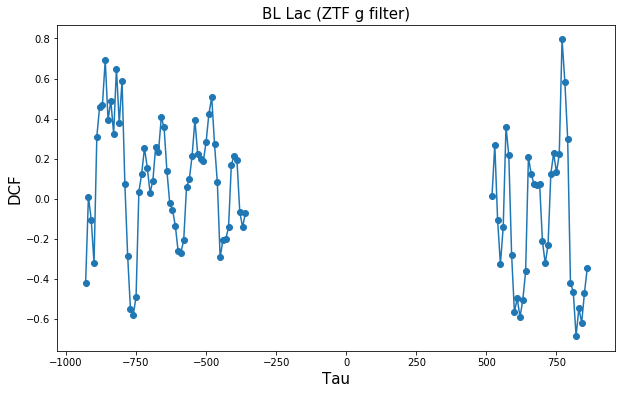

In [59]:
%matplotlib inline
plt.figure(figsize=(10,6))
#plt.plot(xcorr[0], xcorr[2], '.')

plt.errorbar(xcorr[0], xcorr[2], xerr=xcorr[1], yerr=xcorr[3], linestyle="-", marker="o")

plt.title("BL Lac (ZTF g filter)", fontsize=15)
plt.xlabel("Tau", fontsize=15)
plt.ylabel("DCF", fontsize=15)

In [60]:
xcorr = crosscorr(df_ztf[maskr].mjd_ztf, df_ztf[maskr].flux_ztf, df_ztf[maskr].eflux_ztf,
          df_fermi.mjd_fermi, df_fermi.flux_fermi, df_fermi.eflux_fermi, 10)
xcorr

/home/javier/codigos/FermiLat/crossCorrLCCF_ave.py:146: RuntimeWarning: invalid value encountered in double_scalars
  sqrt(var(x, ddof=0) * var(y, ddof=0))


(array([-890., -880., -870., -860., -850., -840., -830., -820., -810.,
        -800., -790., -780., -770., -760., -750., -740., -730., -720.,
        -710., -700., -690., -680., -670., -660., -650., -640., -630.,
        -620., -610., -600., -590., -580., -570., -560., -550., -540.,
        -530., -520., -510., -500., -490., -480., -470., -460., -450.,
        -440., -430., -420., -410., -400., -390., -380., -370., -360.,
        -350., -340., -330., -320., -310., -300., -290., -280., -270.,
        -260., -250., -240., -230., -220., -210., -200., -190., -180.,
        -170., -160., -150., -140., -130., -120., -110., -100.,  -90.,
         -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,  -10.,    0.,
          10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
         100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
         190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,  270.,
         280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,  360.,
      

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 9 Text yticklabel objects>)

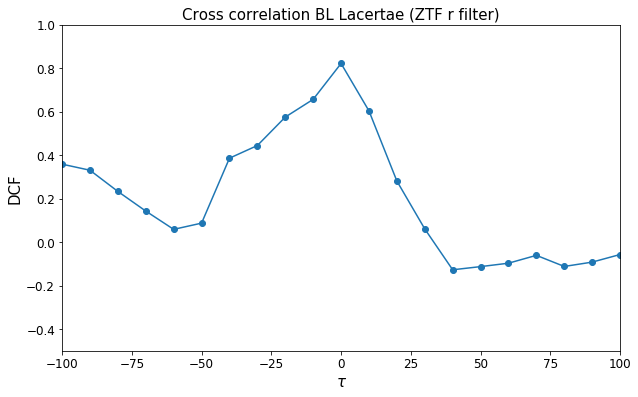

In [61]:
%matplotlib inline
plt.figure(figsize=(10,6))
#plt.plot(xcorr[0], xcorr[2], '.')

plt.errorbar(xcorr[0], xcorr[2], xerr=0, yerr=xcorr[3], linestyle="-", marker="o")

plt.title("Cross correlation BL Lacertae (ZTF r filter)", fontsize=15)
plt.xlabel(r"$\tau$", fontsize=15)
plt.ylabel("DCF", fontsize=15)
plt.xlim(-100, 100)
plt.ylim(-.5, 1)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)